# 1. Training 2D MRI (comparison bp)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np

import torch
import torch.nn
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

from meld.recon import UnrolledNetwork
from meld.util import getAbs, getPhase
from meld.model import pytorch_proximal


import h5py
import mri
import model
import dataloader
import lib_complex as cp
import time as time 
import os

In [2]:
# Setup device
device_no = 3
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
torch.cuda.set_device(device_no)
device = torch.device("cuda:"+str(device_no) if torch.cuda.is_available() else "cpu")

np_dtype = np.float32

In [3]:
# test dataset
datapath = '/mikQNAP/dataset_train_full.h5'
with h5py.File(datapath, 'r') as F:
    print(F.keys())

<KeysViewHDF5 ['imgs', 'maps', 'masks']>


## Loading dataset

In [4]:
# edit this to datapath for 2D brain data
datapath = '/mikQNAP/dataset_train_full.h5'
dataset = dataloader.dataloader(datapath, noise_std = 3e-2)
full_len = len(dataset)
train_len = int(0.945*full_len)
test_len = full_len - train_len
training_dataset, testing_dataset = torch.utils.data.random_split(dataset, [train_len, test_len])
Nbatch_size = 4

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=Nbatch_size, shuffle=False)
testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=Nbatch_size, shuffle=False)

print(len(training_dataset), len(testing_dataset))
img, maps, meas, mask = training_dataset[1]
print(img.shape, maps.shape, meas.shape, mask.shape)

340 20
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
torch.Size([256, 232, 2]) torch.Size([12, 256, 232, 2]) torch.Size([12, 256, 232, 2]) torch.Size([256, 232])


<IPython.core.display.Javascript object>


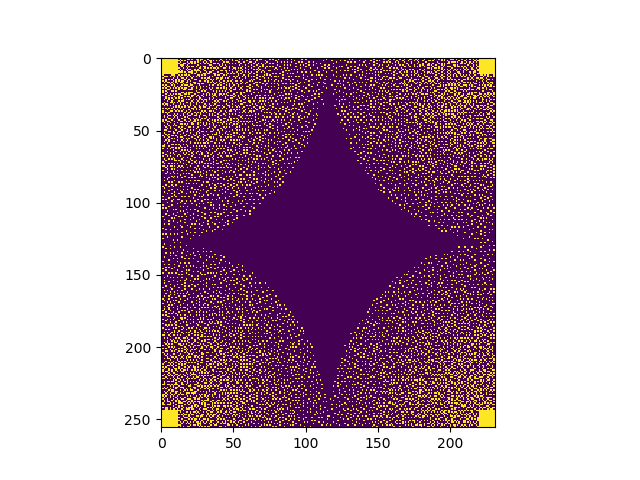

In [5]:
plt.figure()
plt.imshow(mask.cpu().numpy())

## Setting up model and training

In [9]:
metadata = {'num_unrolls': 4, 'lamb': 1, 'alpha': 1e-2}

In [10]:
torch.manual_seed(0)
mri_network = model.model(metadata, device=device, shrinkage_params=(1, 1), num_layers=5)
mri_network_manager = UnrolledNetwork(mri_network.network, None, 11000, device=device, setupFlag=False)
mri_network_manager.meldFlag = True
mri_network_manager.cpList = [-1]

Nepochs = 10
test_freq = 4
learning_rate = 1e-5
optim = torch.optim.Adam(mri_network.network.parameters(),lr=learning_rate)
training_losses = np.zeros(int(Nepochs*(len(training_dataset)/Nbatch_size)))
testing_losses = np.zeros(int(Nepochs*(len(training_dataset)/Nbatch_size)))

## Training

In [ ]:
for ee in range(Nepochs):
    for tt, x_batch in enumerate(training_loader):
        imgs_0, maps_0, meas_0, mask_0 = x_batch
        adj_0 = mri_network.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
        
        optim.zero_grad()
        xN, loss_tmp, _, _ = mri_network_manager.forward(adj_0, imgs_0.to(device), interFlag=False)
        optim.step()
        
        idx = ee*int(train_len/Nbatch_size) + tt
        training_losses[idx] = loss_tmp.detach().cpu().numpy()/Nbatch_size

        if np.mod(idx,test_freq)==0:
            for _, x_batch in enumerate(testing_loader):
                imgs_0, maps_0, meas_0, mask_0 = x_batch
                adj_0 = mri_network.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
                xN, loss_tmp = mri_network_manager.loss_eval(adj_0, imgs_0.to(device))
                testing_losses[idx] = loss_tmp.detach().cpu().numpy()/Nbatch_size

        print('Epoch: {0:d} | Iter: {1:d} | Loss: {2:f}'.format(ee, tt, training_losses[idx]), end="\r")

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 256, 232) (1, 12, 256, 232) (1

In [ ]:
plt.style.use('seaborn-dark')
learning_iter = Nepochs * (train_len/Nbatch_size)
x = np.linspace(0,learning_iter-1,learning_iter)
Nskip = 4

plt.figure(figsize=(4,2))
plt.plot(x[::Nskip],training_losses[::Nskip],'C0s-',label='training')
plt.plot(x[::Nskip],testing_losses[::Nskip],'C1d-',label='testing')
plt.legend()
plt.grid('on')
plt.tight_layout()

## Visualize training

In [ ]:
eval_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=len(testing_dataset), shuffle=False)
with torch.no_grad():
    for bb, x in enumerate(eval_loader):
        imgs_0, maps_0, meas_0, mask_0 = x
        adj_0 = mri_network.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
        recon_0, _ = mri_network_manager.loss_eval(adj_0, imgs_0.to(device))
        recon_0 = recon_0.detach().cpu()
        cg_0 = mri_network.mri_model(torch.zeros_like(adj_0), max_iter = 10, device = device).detach().cpu()
        imgs_0 = imgs_0.cpu()
        adj_0 = adj_0.detach().cpu()

In [ ]:
plt.rcParams['image.cmap'] = 'bone'

idx = 1
plt.figure()
plt.subplot(241)
plt.imshow(getAbs(adj_0[idx, ...]).numpy())
plt.axis('off')
plt.subplot(242)
plt.imshow(getAbs(cg_0[idx, ...]).numpy())
plt.axis('off')
plt.subplot(243)
plt.imshow(getAbs(recon_0[idx, ...]).numpy())
plt.axis('off')
plt.subplot(244)
plt.imshow(getAbs(imgs_0[idx, ...]).numpy())
plt.axis('off')

## Training with backpropagation

In [ ]:
torch.manual_seed(0)
mri_network = model.model(metadata, device=device, shrinkage_params=(1, 1), num_layers=5)
mri_network_manager = UnrolledNetwork(mri_network.network, None, 11000, device=device, setupFlag=False)
mri_network_manager.meldFlag = False
mri_network_manager.cpList = [-1]

optim = torch.optim.Adam(mri_network.network.parameters(),lr=learning_rate)
training_losses_bp = np.zeros(int(Nepochs*(len(training_dataset)/Nbatch_size)))
testing_losses_bp = np.zeros(int(Nepochs*(len(training_dataset)/Nbatch_size)))

In [ ]:
for ee in range(Nepochs):
    for tt, x_batch in enumerate(training_loader):
        imgs_0, maps_0, meas_0, mask_0 = x_batch
        adj_0 = mri_network.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
        
        optim.zero_grad()
        xN, loss_tmp, _, _ = mri_network_manager.forward(adj_0, imgs_0.to(device), interFlag=False)
        optim.step()
        
        idx = ee*int(train_len/Nbatch_size) + tt
        training_losses_bp[idx] = loss_tmp.detach().cpu().numpy()/Nbatch_size

        if np.mod(idx,test_freq)==0:
            for _, x_batch in enumerate(testing_loader):
                imgs_0, maps_0, meas_0, mask_0 = x_batch
                adj_0 = mri_network.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
                xN, loss_tmp = mri_network_manager.loss_eval(adj_0, imgs_0.to(device))
                testing_losses_bp[idx] = loss_tmp.detach().cpu().numpy()/Nbatch_size

        print('Epoch: {0:d} | Iter: {1:d} | Loss: {2:f}'.format(ee, tt, training_losses_bp[idx]), end="\r")

In [ ]:
plt.style.use('seaborn-dark')
learning_iter = Nepochs * (train_len/Nbatch_size)
x = np.linspace(0,learning_iter-1,learning_iter)
Nskip = 32

plt.figure(figsize=(4,2))
plt.plot(x[::Nskip],testing_losses[::Nskip],'C0s-',label='training')
plt.plot(x[::Nskip],testing_losses_bp[::Nskip],'C1d-',label='testing')
plt.legend()
plt.grid('on')
plt.tight_layout()

## training function

In [9]:
def train(man, opt, unroll, iters, stats):
    writer = SummaryWriter()

    num_train_batches = train_len / batch_size
    num_test_batches = test_len / batch_size
    for i in range(iters):
        print(f'iteration {i}')
        curr_train_loss = 0
        for i_batch, sample_batched in enumerate(train_loader):
            imgs_0, maps_0, meas_0, mask_0 = sample_batched
            adj_0 = man.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
            man.network.zero_grad()
            xN, loss_temp, _, _ = unroll.forward(torch.zeros_like(adj_0), imgs_0.to(device))
            print(f'batch {i_batch} of {int(num_train_batches)}, loss: {loss_temp.item()}')
            curr_train_loss += loss_temp.item()
            opt.step()
            
        curr_test_loss = 0
        for i_batch, sample_batched in enumerate(test_loader):
            with torch.no_grad():
                imgs_0, maps_0, meas_0, mask_0 = sample_batched
                adj_0 = man.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
                xN, loss_temp = unroll.loss_eval(torch.zeros_like(adj_0), imgs_0.to(device))
                curr_test_loss += loss_temp.item()
        
        writer.add_scalar('avg train loss, batch/epoch', curr_train_loss / num_train_batches, i)
        writer.add_scalar('avg test loss, batch/epoch', curr_test_loss / num_test_batches, i)        
        
        if i == 0:
            imgs_test, maps_test, meas_test, mask_test = imgs_0, maps_0, meas_0, mask_0
            writer.add_image("ground truth", getAbs(imgs_test[0,...]).unsqueeze(0))
            adj_disp = man.initialize(imgs_test.to(device), maps_test.to(device), meas_test.to(device), mask_test.to(device), device)                        
            recon = man.mri_model(torch.zeros_like(adj_disp), device=device, max_iter=100)
            writer.add_image("base recon", getAbs(recon[0,...]).unsqueeze(0))
            writer.add_image("adjoint", getAbs(adj_disp[0,...]).unsqueeze(0))
        
        adj_disp = man.initialize(imgs_test.to(device), maps_test.to(device), meas_test.to(device), mask_test.to(device), device)                        
        x, _ = unroll.loss_eval(torch.zeros_like(adj_disp).to(device), imgs.to(device))        
        writer.add_image('test output/epoch', getAbs(x[0,...]).unsqueeze(0), i)
        
        stats.append((curr_train_loss/num_train_batches, curr_test_loss/num_test_batches))

In [10]:
%%notify
train(mri_network_manager, optimizer, mri_network_unroller, 200, stats)

iteration 0
batch 0 of 72, loss: 0.010505781508982182
batch 1 of 72, loss: 0.01006715651601553
batch 2 of 72, loss: 0.010107317939400673
batch 3 of 72, loss: 0.009042026475071907
batch 4 of 72, loss: 0.009149803780019283
batch 5 of 72, loss: 0.009858392179012299
batch 6 of 72, loss: 0.00849261786788702
batch 7 of 72, loss: 0.009054195135831833
batch 8 of 72, loss: 0.008664452470839024
batch 9 of 72, loss: 0.008967078290879726
batch 10 of 72, loss: 0.008258035406470299
batch 11 of 72, loss: 0.00857139565050602


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

## Saving outputs of training with MELD

In [26]:
testing_outputs_meld = []
for i_batch, sample_batched in enumerate(test_loader):
    with torch.no_grad():
        imgs_0, maps_0, meas_0, mask_0 = sample_batched
        adj_0 = mri_network_manager.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
        xN, loss_temp = mri_network_unroller.loss_eval(torch.zeros_like(adj_0), imgs_0.to(device))
        for i in range(batch_size):
            testing_outputs_meld.append(cp.r2c(xN[i].cpu().numpy()))

In [30]:
conj_grad_outputs = []
adj_outputs = []
for i_batch, sample_batched in enumerate(test_loader):
    with torch.no_grad():
        imgs_0, maps_0, meas_0, mask_0 = sample_batched
        adj_0 = mri_model.batch(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
        recon = mri_model(zeros_test, device = device, max_iter=100)
        for i in range(batch_size):
            adj_outputs.append(cp.r2c(adj_0[i].cpu().numpy()))
            conj_grad_outputs.append(cp.r2c(recon[i].cpu().numpy()))

In [32]:
conj_grad_arr = np.array(conj_grad_outputs)
adj_outputs = np.array(adj_outputs)
testing_outputs_arr = np.array(testing_outputs)

In [33]:
print(testing_outputs_arr.shape, conj_grad_arr.shape, adj_outputs.shape)

(72, 256, 232) (72, 256, 232) (72, 256, 232)


In [29]:
import scipy
scipy.io.savemat("2D_MELD_testing_outputs.mat", {"testing_outputs": testing_outputs_arr})
scipy.io.savemat("2D_CG_testing_outputs.mat", {"testing_outputs": conj_grad_arr})
scipy.io.savemat("2D_adjoint_testing_outputs.mat", {"testing_outputs": adj_outputs})

## Training without MELD

In [11]:
# keep same initialization experiment?
mri_network_manager_no_meld = model.model(metadata, device=device, debug=False, shrinkage_params=(1, 1), num_layers=5, num_filters=64, conj=True)
optimizer_no_meld = torch.optim.Adam(mri_network_manager_no_meld.network.parameters(), lr=1e-5)
mri_network_unroller_no_meld = UnrolledNetwork(mri_network_manager_no_meld.network, None, 11000, loss_func, device=device, setupFlag=False)
mri_network_unroller_no_meld.meldFlag = False
mri_network_unroller_no_meld.cpList = [-1]
stats = []

In [ ]:
train(mri_network_manager_no_meld, optimizer_no_meld, mri_network_unroller_no_meld, 200, stats)

## Saving outputs of training without MELD

In [12]:
testing_outputs_no_meld = []
for i_batch, sample_batched in enumerate(test_loader):
    with torch.no_grad():
        imgs_0, maps_0, meas_0, mask_0 = sample_batched
        adj_0 = mri_network_manager_no_meld.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
        xN, loss_temp = mri_network_unroller_no_meld.loss_eval(torch.zeros_like(adj_0), imgs_0.to(device))
        for i in range(batch_size):
            testing_outputs_no_meld.append(cp.r2c(xN[i].cpu().numpy()))

In [13]:
testing_outputs_no_meld_arr = np.array(testing_outputs_no_meld)

In [ ]:
scipy.io.savemat("2D_no_MELD_testing_outputs.mat", {"testing_outputs": testing_outputs_no_meld_arr})